In [1]:
import sys; sys.version

'3.9.5 (default, Nov 23 2021, 15:27:38) \n[GCC 9.3.0]'

Preferred way to open this Jupyter notebook is:

```
conda deactivate
source ~/myenv/bin/activate
cd ~/Desktop/palau-guts-experiment
jupyter lab
```
Should be run using **python 3.9** in a kernel named **Python 3 (ipykernel)**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import lifelines # for survival analysis
import os
import pyautogui

In [3]:
TREATMENT_DATE = '2022-12-06'

## Read beetles.csv

In [4]:
df_beetles = pd.read_csv('beetles.csv')
df_beetles

,sn,sex,treatment
0,1,M,V
1,2,M,C
2,3,M,C
3,4,M,V
4,5,M,V
...,...,...,...
222,223,F,V
223,224,F,V
224,225,F,V
225,226,F,V


In [5]:
assert(df_beetles.sn.is_unique)

## Read mortality.csv

In [6]:
df_mortality = pd.read_csv('mortality.csv', parse_dates=['date'])
df_mortality

,sn,date
0,169,2022-12-09
1,27,2022-12-09
2,124,2022-12-09
3,24,2022-12-09
4,11,2022-12-09
...,...,...
198,2,2023-03-29
199,149,2023-03-29
200,164,2023-03-29
201,167,2023-03-29


In [7]:
# assert(df_mortality.sn.is_unique)
dups = df_mortality.duplicated(subset=['sn'], keep=False)
df_dups = df_mortality[dups]
df_dups = df_dups.sort_values(['sn','date'])
df_dups

,sn,date
72,6,2023-01-04
73,6,2023-01-09
70,9,2023-01-04
191,9,2023-03-20
68,15,2023-01-04
186,15,2023-03-17
41,25,2022-12-26
85,25,2023-01-16
25,50,2022-12-19
113,50,2023-01-26


In [8]:
# Mark all duplicate records except for the last as "reject"

dups = df_mortality.duplicated(subset=['sn'], keep='last')
df_mortality['reject'] = dups
df_mortality = df_mortality[df_mortality.reject==False]
df_mortality

,sn,date,reject
0,169,2022-12-09,False
1,27,2022-12-09,False
2,124,2022-12-09,False
3,24,2022-12-09,False
4,11,2022-12-09,False
...,...,...,...
198,2,2023-03-29,False
199,149,2023-03-29,False
200,164,2023-03-29,False
201,167,2023-03-29,False


## Add days_post_treatment column

In [9]:
df_mortality['days_post_treatment'] = (df_mortality['date'] - pd.to_datetime(TREATMENT_DATE)).dt.days
df_mortality

/tmp/ipykernel_10560/1542106039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mortality['days_post_treatment'] = (df_mortality['date'] - pd.to_datetime(TREATMENT_DATE)).dt.days


,sn,date,reject,days_post_treatment
0,169,2022-12-09,False,3
1,27,2022-12-09,False,3
2,124,2022-12-09,False,3
3,24,2022-12-09,False,3
4,11,2022-12-09,False,3
...,...,...,...,...
198,2,2023-03-29,False,113
199,149,2023-03-29,False,113
200,164,2023-03-29,False,113
201,167,2023-03-29,False,113


## Merge beetles and mortality tables

In [10]:
df = df_beetles.merge(df_mortality, how='left')
df['dead'] = df['days_post_treatment'].notna()
df['days_post_treatment'] = df.days_post_treatment.fillna(df.days_post_treatment.max())
df

,sn,sex,treatment,date,reject,days_post_treatment,dead
0,1,M,V,2023-02-10,False,66.0,True
1,2,M,C,2023-03-29,False,113.0,True
2,3,M,C,2022-12-21,False,15.0,True
3,4,M,V,2022-12-09,False,3.0,True
4,5,M,V,2023-01-30,False,55.0,True
...,...,...,...,...,...,...,...
222,223,F,V,2022-12-13,False,7.0,True
223,224,F,V,2022-12-19,False,13.0,True
224,225,F,V,2022-12-26,False,20.0,True
225,226,F,V,2022-12-28,False,22.0,True


## Statistics

In [11]:
treated = df.treatment == 'V'
untreated = df.treatment == 'C'

stats = lifelines.statistics.logrank_test(
    durations_A = df[treated]['days_post_treatment'],
    durations_B = df[untreated]['days_post_treatment'],
    event_observed_A = df[treated]['dead'],
    event_observed_B = df[untreated]['dead'])
print(stats)

if stats.p_value < 0.05:
    stats_result = f'Difference between curves is significant (logrank test; p = {stats.p_value:.3f})'
else:
    stats_result = f'Difference between curves is not significant\n(logrank test; p = {stats.p_value:.3f})'
print(stats_result)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.40 0.12      3.04
Difference between curves is not significant
(logrank test; p = 0.121)


## Plot

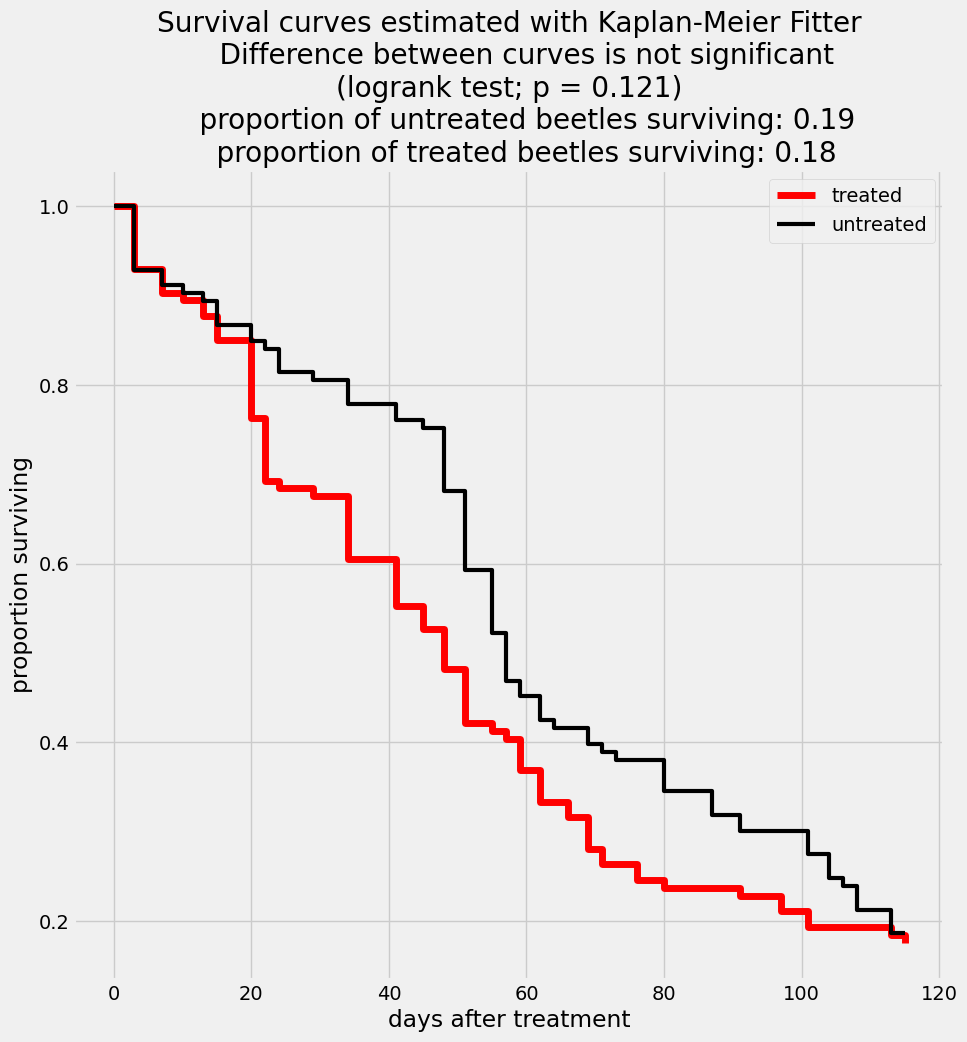

In [12]:
ax = plt.subplot()
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations=df[treated]['days_post_treatment'],
        event_observed=df[treated]['dead'], 
        label='treated')
kmf.plot(figsize=(8,8), ax=ax, ci_show=False, color='red', linewidth=5)

kmf.fit(durations=df[untreated]['days_post_treatment'], 
        event_observed=df[untreated]['dead'], 
        label='untreated')
kmf.plot(figsize=(10,10), ax=ax, ci_show=False, color='black', linewidth=3)

title = f'''Survival curves estimated with Kaplan-Meier Fitter
    {stats_result}
    proportion of untreated beetles surviving: {1 - sum(untreated & df.dead)/sum(untreated):.2f}
    proportion of treated beetles surviving: {1 - sum(treated & df.dead)/sum(treated):.2f}'''

plt.title(title)
plt.xlabel('days after treatment')
plt.ylabel('proportion surviving')
plt.savefig('results.png', bbox_inches='tight')
plt.show();

In [13]:
df_eggcount = pd.read_csv('eggcount.csv', parse_dates=True)
df_eggcount = df_eggcount.assign(total_larvae=lambda x: (x['L1']+x['L2']+x['L3'])) 
df_eggcount = df_eggcount.merge(df_beetles)
df_eggcount

,sn,date_died,date_inspected,eggs,L1,L2,L3,total_larvae,sex,treatment
0,133,2023-01-30,2023-01-30,9,1,0,0,1,F,V
1,97,2023-01-30,2023-01-30,7,0,0,0,0,F,C
2,191,2023-01-30,2023-01-30,0,19,0,0,19,F,C
3,177,2023-01-30,2023-01-30,0,0,0,0,0,F,C
4,122,2023-01-30,2023-01-30,0,0,0,0,0,F,C
5,142,2023-01-30,2023-01-30,3,0,0,0,0,F,C
6,194,2023-01-30,2023-01-30,0,0,1,0,1,F,C
7,186,2023-02-03,2023-02-03,0,0,0,0,0,F,V
8,129,2023-02-03,2023-02-03,0,0,0,0,0,F,V
9,136,2023-02-03,2023-02-03,0,3,0,0,3,F,C


In [14]:
mean_larvae_c = df_eggcount.query("treatment=='C'").total_larvae.mean()
mean_larvae_v = df_eggcount.query("treatment=='V'").total_larvae.mean()
print(f'{mean_larvae_c=:.2f}')
print(f'{mean_larvae_v=:.2f}')

mean_larvae_c=1.41
mean_larvae_v=0.65


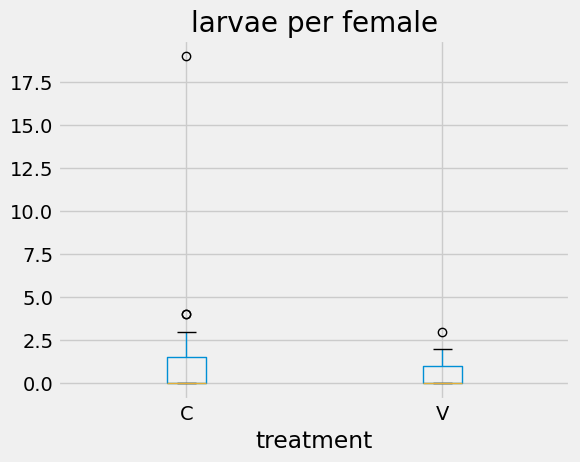

In [15]:
df_eggcount.boxplot(column='total_larvae', by='treatment')
plt.title('larvae per female')
plt.suptitle('')
plt.show()

In [ ]:
# Save this notebook
# This is run to make sure that the current status of this notebook is saved in GitHub

pyautogui.keyDown('ctrl')
pyautogui.write('s')
pyautogui.keyUp('ctrl')

In [ ]:
# Update GitHub repo

os.system('git pull')
os.system('git add .')
os.system('git commit -m "safety"')
os.system('git push')